### 세팅

In [1]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pylab as plt

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [3]:
LOANS_INCOME_CSV = DATA / 'loans_income.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'

### 임의표본 추출과 표본편향
- 임의표본추출(랜덤표본추출) : 무작위로 표본 추출
- 층화표본추출 : 모집단을 층으로 나눈 뒤, 각 층에서 무작위로 추출
- 계층(stratum) : 공통된 특징을 가진 모집단의 동종 하위 그룹
- 단순임의표본 : 모집단 층화 없이 임의표본 추출로 얻은 표본
- 편향(bias) : 계통상의 오류 (통계적 편향은 측정 과정 or 표본추출 과정에서 발생하는 계통적인systematic 오차를 의미한다.)
- 표본편향 (sample bias) : 모집단을 잘못 대표하는 표본
- 비임의(nonrandom) : 아무리 랜덤표본이라 해도, 어떤 표본도 모집단을 정확하게 대표할 수는 없다.

### 선택편향
- 선택편향은 데이터를 의식적이든 무의식적이든 선택적으로 고르는 관행을 의미한다. 결국 오해의 소지가 있거나 단편적인 결론을 얻게 된다.
- 선택편향 : 관측 데이터를 선택하는 방식 때문에 생기는 편향
- 방대한 검색 효과 (vast search effect) : 중복 데이터 모델링이나 너무 많은 예측 변수를 고려하는 모델링에서 비롯되는 편향 혹은 비재현성
- 성능을 검증하기 위해 둘 이상의 홀드아웃(Holdout)세트를 이용하면 방지할 수 있다.
- 또한 데이터 마이닝 모델에서 제시하는 예측들을 검증하기 위해 목표값 섞기(Target shuffling, 순열검정)을 추천했다.
- 평균으로 회귀(regression to the mean) : 어떤 변수를 연속적으로 측정했을 때 나타나는 현상. 예외 경우를 너무 특별히 생각하고 의미를 부여하면 선택편향으로 이어질 수 있다.
- 가설을 구체적으로 명시하고 임의표본추출 원칙에 따라 데이터를 수집하면 편향을 피할 수 있다.

### 표본분포
- 데이터 분포(data distribution) : 어떤 데이터 집합에서의 각 개별 값의 도수분포
- 표본분포(sampling distribution) : 여러 표본들 혹은 재표본들로부터 얻은 표본 통계량의 도수분포
- 중신 극한정리(central limit theorem) : 표본크기가 커질수록 표본분포가 정규분포를 따르는 경향
- 표준오차 (standard error) : 어떤 표본들로부터 얻은 표본통계량의 변량(개별 데이터 값들의 변량을 뜻하는 표준편차와 혼동하지 말것)
- 평균과 같은 표본 통계량의 분포는 데이터 자체의 분포보다 규칙적이고 종 모양일 가능성이 높다. 또한 표본이 클수록 표본통계량의 분포가 좁아진다.

In [4]:
loans_income = pd.read_csv(LOANS_INCOME_CSV).squeeze('columns')

sample_data = pd.DataFrame({
    'income': loans_income.sample(1000),
    'type': 'Data',
})

# 5개의 값의 편균으로 이뤄진 표본 하나
sample_mean_05 = pd.DataFrame({
    'income': [loans_income.sample(5).mean() for _ in range(1000)],
    'type': 'Mean of 5',
})

# 20개의 값의 평균으로 이뤄진 표본 하나
sample_mean_20 = pd.DataFrame({
    'income': [loans_income.sample(20).mean() for _ in range(1000)],
    'type': 'Mean of 20',
})

results = pd.concat([sample_data, sample_mean_05, sample_mean_20])
print(results.head())

         income  type
24101  105294.0  Data
37848   40000.0  Data
42901   80000.0  Data
28733   80000.0  Data
43165   76000.0  Data


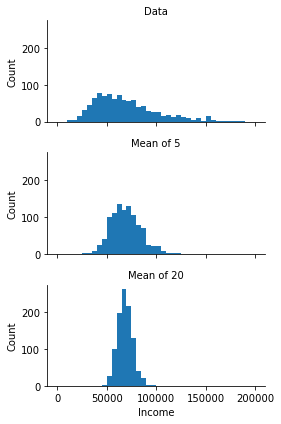

In [5]:
# 개별 데이터 값의 히스토그램은 넓게 분산되어 있고, 한쪽으로 기울어져 있다.
# 5와 20의 평균에 대한 히스토그램은 갈수록 좁고 벨 모양이 된다.

# 이를 [중심극한정리] 라고 한다. 
# 모집단이 정규분포가 아니더라도, 표본크기가 충분하고 데이터가 정규성을 크게 이탈하지 않는 경우, 여러표본에서 추출한 평균은 종모양의 정규곡선을 따른다.
# 중심극한정리 덕분에, 신뢰구간이나 가설검정을 계산하는데 t분포 같은 정규근사 공식을 사용할 수 있다.

g = sns.FacetGrid(results, col='type', col_wrap=1, 
                  height=2, aspect=2)
g.map(plt.hist, 'income', range=[0, 200000], bins=40)
g.set_axis_labels('Income', 'Count')
g.set_titles('{col_name}')

plt.tight_layout()
plt.show()

### 표준오차
- 표준오차는 통계에 대한 표본분포의 변동성을 한마디로 말해주는 단일 측정 지표이다.
- 표본크기가 커지면 표준오차는 작아진다. 표준오차와 표본크기 사이의 관계를 때로는 n 제곱근의 법칙이라고 한다.(표준오차를 2배 줄이려면, 표본크기를 4배 증가시켜야한다.)
- 표준오차를 측정할 때 고려사항
1. 모집단에서 완전히 새로운 샘플들을 많이 수집
2. 각각의 새 샘플에 대해 통계량(예:평균)을 계산한다.
3. 2단계에서 얻은 통계량의 표준편차를 계산한다. 이것을 표준오차의 추정치로 사용한다.
- 실질적으로 표준오차를 추정하기 위해 새 샘플을 수집하는 접근 방식은 일반적으로 불가능하다.(통계적으로도 낭비가 심함)
- 새로운 표본을 뽑는 대신 부트스트랩 재표본을 사용할 수 있다.

### 부트스트랩(Bootstrap) - 복원추출
- 부트스트랩 : 통계량이나 모수의 표본분포를 추정하는 쉽고 효과적인 방법, 현재 있는 표본에서 추가적으로 표본을 복원추출하고 각 표본에 대한 통계량과 모델을 다시 계산하는 절차
- 부트스트랩 표본(bootstrap sample) : 관측 데이터 집합으로부터 얻은 복원추출 표본
- 재표본추출(재표집,리샘플링resampling) : 관측 데이터로부터 반복해서 표본추출하는 과정, 부트스트랩과 순열(셔플링) 과정을 포함한다.
- 반복 횟수가 많을수록 표준오차나 신뢰구간에 대한 추정이 명확해진다.
- 부트스트랩은 표본크기가 작은 것을 보완하기 위한 것이 아니다. 새 데이터를 만드는것도 아니며, 기존 데이터 집합의 빈곳을 채우는 것도 아니다.
- 모집단에서 추가적으로 표본을 뽑는다고 할 때, 그 표본이 얼마나 원래 표본과 비슷할지를 알려줄 뿐이다.

### 재표본추출 대 부트스트래핑
- 재표본추출 : 여러 표본이 결합되어 비복원추출을 수행할 수 있는 순열 과정을 포함한다.
- 부트스트랩 : 항상 관측된 데이터로부터 복원추출한다.

### 신뢰구간
- 신뢰수준(confidence level) : 같은 모집단으로부터 같은 방식으로 얻은, 관심 통계량을 포함할 것으로 예상되는 신뢰구간의 백분율
- 구간끝점(interval endpoint) : 신뢰구간의 최상위, 최하위 끝점
